In [2]:
import pandas as pd
df = pd.read_csv('StumptownWholesale.csv')
df.head()

,customer_id,is_cafe,facility_sqft,first,last,spend_total,cold_brew_cases,hair_bender_cases,holler_mountain_cases,colombia_el_jordan_cases,guatemala_el_injerto_bourbon_cases,seasonal_single_origin_cases,buyer
0,45875,0,709,8,6,720,0,0,1,1,0,0,0
1,15376,1,1008,23,23,362,0,0,0,2,0,0,0
2,16802,0,2098,11,13,362,1,0,0,0,0,0,0
3,14680,1,1175,43,19,2161,1,3,0,0,2,2,1
4,89334,0,1009,15,9,366,1,1,0,0,0,0,0


# **Part I) Logistic Regression and Gains Graphs**
**Question 1**: Run a logistic regression (also known as logit model) where the variable ‘buyer’ is your dependent variable (i.e., outcome variable). For predictors, use every other variable in the data except for ‘customer_id’. Do not use any interaction terms in your model. Use the summary() command to report coefficient tables. Please explain if estimated coefficients make sense to you from a managerial perspective.

In [3]:
import statsmodels.formula.api as smf

all_cols = [c for c in df.columns if c not in ['customer_id']]
df = df[all_cols].dropna().copy()
df['buyer'] = df['buyer'].astype(int)

predictors = [c for c in df.columns if c != 'buyer']
formula = 'buyer ~ ' + ' + '.join(predictors)


model = smf.logit(formula, data=df).fit(disp=False)
print(model.summary())

                           Logit Regression Results                           
Dep. Variable:                  buyer   No. Observations:                15000
Model:                          Logit   Df Residuals:                    14988
Method:                           MLE   Df Model:                           11
Date:                Sat, 18 Oct 2025   Pseudo R-squ.:                  0.1669
Time:                        03:07:52   Log-Likelihood:                -3699.3
converged:                       True   LL-Null:                       -4440.2
Covariance Type:            nonrobust   LLR p-value:                2.838e-311
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                             -2.5620      0.165    -15.539      0.000      -2.885      -2.239
is_cafe                                0.7662      0.065   

Interpretation of estimated coefficients:

Intercept — Baseline chance to buy is low for an “average” account; that’s normal for this kind of campaign.

is_cafe — Cafés are more likely to order; they rotate menus and sell more single-origin, so this makes sense.

facility_sqft — Store size doesn’t add much once we already know their buying history; square footage is a weak proxy.

first — Accounts whose relationship started long ago are a bit less likely to respond now; older ties can go cold.

last — If it’s been longer since the last purchase, the chance to buy drops; classic recency effect.

spend_total — Higher past spending means a higher chance to buy; bigger customers act more often.

cold_brew_cases — Heavy cold-brew buyers are less likely to take a seasonal single-origin; different use case and audience.

hair_bender_cases — Strong buyers of this core espresso are more likely to try the promo; active, engaged shops explore more.

holler_mountain_cases — Blend-focused buyers are less likely to switch to a seasonal single-origin; fits a value/consistency preference.

colombia_el_jordan_cases — Similar to above: these buyers lean toward a set profile rather than rotating seasonals.

guatemala_el_injerto_bourbon_cases — Premium single-origin buyers are prime targets; they’re already in the habit of trying special lots.

seasonal_single_origin_cases — On its own it looked important, but after controlling for everything else it adds little; its earlier signal was mostly standing in for overall customer scale and recency.

Managerially: cafés and customers active on core SKUs (Hair Bender, Guatemala El Injerto Bourbon) and recent purchasers are most promising; lapsed or “other-blend–heavy” buyers respond less

**Question 2**: Create a column that shows the probability predictions of the logit model. Then
make deciles (quantiles of order 10) based on logit probability predictions. In other words,
create a column that shows whether each customer belongs to decile 1, decile 2, … , or
decile 10. As we have established throughout this course, the decile with the smallest
number (in this case decile 1) should show the highest probabilities and decile 10 is for the
lowest probability. Report a table that shows the response rate in each decile.

In [5]:
# --- Predictions ---
df['preds'] = model.predict(df)
df[['buyer','preds']].head()

# --- Simple deciles (1 = highest probability) ---
df['decile'] = pd.qcut(-df['preds'], 10, labels=[i for i in range(1,11)])
deciles = (df.groupby('decile')
             .agg(customers=('buyer','size'),
                  buyers=('buyer','sum'),
                  response_rate=('buyer','mean'),
                  avg_p_hat=('preds','mean'))
             .reset_index()
             .sort_values('decile'))
print("\n=== Deciles (1=highest) ===\n")
print(deciles.round(4))


=== Deciles (1=highest) ===

  decile  customers  buyers  response_rate  avg_p_hat
0      1       1500     524         0.3493     0.3377
1      2       1500     214         0.1427     0.1540
2      3       1500     150         0.1000     0.1058
3      4       1500     122         0.0813     0.0790
4      5       1500      88         0.0587     0.0608
5      6       1500      63         0.0420     0.0470
6      7       1500      54         0.0360     0.0358
7      8       1500      44         0.0293     0.0262
8      9       1500      31         0.0207     0.0177
9     10       1500      18         0.0120     0.0080


/tmp/ipython-input-3712942372.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  deciles = (df.groupby('decile')


**Question 3**: Plot the Gains graph for the logit model. To create the gains graph, you can use
Microsoft Excel. Note that the Gains graph should have the straight line that represents the
random model performance as the baseline.

**Response on Microsoft Excel**

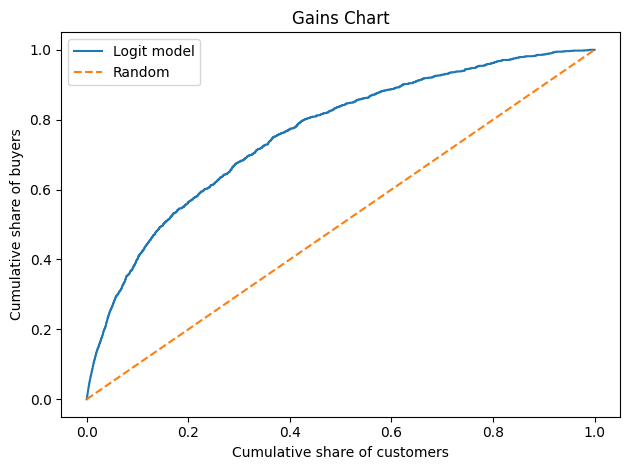

In [6]:
import numpy as np
import matplotlib.pyplot as plt

sorted_df = df.sort_values('preds', ascending=False).reset_index(drop=True)
sorted_df['cum_customers_pct'] = (np.arange(1, len(sorted_df)+1) / len(sorted_df))
sorted_df['cum_buyers_pct'] = (sorted_df['buyer'].cumsum() / sorted_df['buyer'].sum())

plt.figure()
plt.plot(sorted_df['cum_customers_pct'], sorted_df['cum_buyers_pct'], label='Logit model')
plt.plot([0,1],[0,1],'--', label='Random')
plt.xlabel('Cumulative share of customers'); plt.ylabel('Cumulative share of buyers')
plt.title('Gains Chart'); plt.legend(); plt.tight_layout(); plt.show()

# **Part II) Economic Analysis**
**Question 4**: What is the break-even response rate? In other words, how high the customer’s
predicted probability should be so that we can classify them as profitable targets?

In [9]:
# Case economics
cost_per_offer = 20.0                     # $13 ship + $7 COGS (sample)
profit_per_buyer = 440.0 - (30.0+140.0)   # revenue - (ship+COGS on order) = $270
print("\nprofit_per_buyer =", profit_per_buyer)

# Break-even probability
bep = cost_per_offer / profit_per_buyer   # 20 / 270 ≈ 0.074074
print("Break-even p* =", f"{bep * 100:.2f}%")

# Whom to mail?
df['mailto'] = (df['preds'] >= bep).astype(int)


profit_per_buyer = 270.0
Break-even p* = 7.41%


**Question 5**: Stumptown now wants to ship the free sample only to customers who they
deem profitable, i.e., those with the predicted probability of buying above the break-even
response rate. Out of the remaining 45,000 customers in the database, how many of them
would be targeted? What is the expected response rate among those targeted? What would
be the expected profit in dollars?

In [12]:
# Proportion targeted
target_rate = df['mailto'].mean()
print("Target rate (sample) =", f"{target_rate * 100:.2f}%")

# Scale to the 45,000 remaining accounts (sample ~15k → scale x3)
total_customers = 45000
targeted_customers = target_rate * total_customers
print("Targeted customers (45k) =", int(round(targeted_customers)))

# Actual response rate observed among the to-be-targeted group (like logistic_.py style)
targeted_response_rate = df.loc[df['mailto']==1, 'buyer'].mean()
print("Observed response rate among targeted =", f"{targeted_response_rate * 100:.2f}%")

# Expected buyers and profit (logit targeting)
expected_buyers_logit = targeted_response_rate * targeted_customers
profit_logit = profit_per_buyer * expected_buyers_logit - targeted_customers * cost_per_offer
print("Expected buyers (targeted, 45k scale) =", round(expected_buyers_logit,2))
print("Expected PROFIT (targeted) = ${:,.2f}".format(profit_logit))

Target rate (sample) = 37.11%
Targeted customers (45k) = 16701
Observed response rate among targeted = 17.66%
Expected buyers (targeted, 45k scale) = 2949.0
Expected PROFIT (targeted) = $462,210.00


**Question 6**: Compare the expected profits you have obtained in Question 5 and compare it
to the expected profit of a scenario where Stumptown does not use analytics to guide their
targeting decision, instead they ship the offer to everyone in the remaining data as well (in
other words, all 45,000 customers get the 1-lb free sample). Comment on any improvements
that you observe in Logit model compared to the case where the company targets all 45,000
customers.

In [13]:
# --- Benchmark: mail to ALL 45k (same simple style) ---
overall_response_rate = df['buyer'].mean()
expected_buyers_all = overall_response_rate * total_customers
profit_all = profit_per_buyer * expected_buyers_all - total_customers * cost_per_offer
print("\n[Send to ALL] response rate =", round(overall_response_rate,4))
print("[Send to ALL] expected buyers =", round(expected_buyers_all,2))
print("[Send to ALL] PROFIT = ${:,.2f}".format(profit_all))


[Send to ALL] response rate = 0.0872
[Send to ALL] expected buyers = 3924.0
[Send to ALL] PROFIT = $159,480.00


In [14]:
# --- Tiny summary printout ---
print("\n=== SUMMARY ===")
print(f"Break-even p*: {bep:.4%}")
print(f"Target rate: {target_rate:.2%}  → {int(round(targeted_customers))} / 45,000")
print(f"Targeted RR (observed): {targeted_response_rate:.2%}")
print(f"Profit (Targeted): ${profit_logit:,.0f}")
print(f"Profit (Send ALL): ${profit_all:,.0f}")


=== SUMMARY ===
Break-even p*: 7.4074%
Target rate: 37.11%  → 16701 / 45,000
Targeted RR (observed): 17.66%
Profit (Targeted): $462,210
Profit (Send ALL): $159,480


With analytics, we would ship samples only to the 16,701 accounts whose predicted probability clears the profit break-even. That smaller, higher-quality pool responds at 17.67% and generates an expected profit of 462,210. In contrast, if we skip targeting and mail to all 45,000 accounts, the program’s expected profit falls to 159,480. We can see that the model delivers 302,730 more profit, which is about a 190% lift over mailing to everyone. The model achieves this by concentrating buyers and cutting waste. Profit per mailed account jumps from 3.54 to 27.68 (8 times), and mail cost per buyer halves from 229 to 113. The targeted group’s 17.67% hit rate is roughly 2x the list’s base rate (~8.7%).


# **Part III) Interpretation of An Alternative Model**
**Question 7**: Now instead of running the logistic regression model with all variables (except
for customer_id), this time we only run the logit model with one variable of
‘seasonal_single_origin_cases’ and no other variable. In other words, we use the
following formula in the new logistic regression:
'buyer ~ seasonal_single_origin_cases'
Look at the coefficient of seasonal single origin in the new model and compare it to the
seasonal single origin coefficient you observed in Question 1 (full model). Comment on why
you think these two coefficients are different.

In [ ]:
import statsmodels.formula.api as smf
from statsmodels.stats.power import NormalIndPower

In [16]:
new_model = smf.logit('buyer ~ seasonal_single_origin_cases', data=df).fit()
print(new_model.summary())
df['logit-preds2'] = new_model.predict(df)

Optimization terminated successfully.
         Current function value: 0.294688
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  buyer   No. Observations:                15000
Model:                          Logit   Df Residuals:                    14998
Method:                           MLE   Df Model:                            1
Date:                Sat, 18 Oct 2025   Pseudo R-squ.:                0.004469
Time:                        03:21:15   Log-Likelihood:                -4420.3
converged:                       True   LL-Null:                       -4440.2
Covariance Type:            nonrobust   LLR p-value:                 2.978e-10
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       -2.4593      0.035    -71.033      0.000

**Comments**: With only one predictor, the coefficient for seasonal_single_origin_cases is 0.2503 (strong and significant). In the full model with many predictors, it drops to 0.0037 (not significant). This happens because the one-variable model mixes together many effects. Seasonal purchases are related to other things—like customer size, how recently they bought, and what products they buy. When we don’t include those other factors, the seasonal variable “borrows” their effect and looks strong. When we add proper controls, we see the true, small effect of seasonal cases by themselves.

Q8. Yes, Stumptown should run a new test for the Ethiopia coffee next year. The old test was for Honduras El Puente at a different time. Customer taste and behavior can change with the coffee’s origin, flavor profile, and season. A new randomized test (with a control group that gets no sample) will measure the extra impact of sending samples, update the break-even rule, and let the team try better options (for example, smaller sample size or different messages) to maximize profit, not just response rate.

Q9. Main limits: there was no control group, so we cannot be sure how many orders were caused by the sample versus normal buying. The outcome was a simple “bought ≥20 lb or not,” which throws away information about order size and profit. Results also come from one product and time period, so they may not generalize. The model’s probability calibration and robustness were not shown, and differences across customer segments were not deeply studied. Improvements: run a stratified randomized test with a control group, optimize for profit (not just yes/no buying), test multiple versions (sample size, message, timing), check and fix probability calibration, and try cheaper sampling logistics to lower the break-even threshold.